# 데이터 로드

필요 모듈을 import 하고, 분석에 필요한 feature들을 추출합니다.

In [122]:
# 필요 모듈 import
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from statsmodels.formula.api import ols
from matplotlib import rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings

# 한글 깨짐 현상 방지(개발자별 노트북 환경을 고려하여 함수 제작)
def font(name):
    if name == 'sj':
        plt.rc('font', family='AppleGothic')
        plt.rcParams['axes.unicode_minus'] = False

    elif name == 'wh':
        plt.rc("font", family="Malgun Gothic")
        plt.rcParams['axes.unicode_minus'] = False

font('sj')

# warning 무시 코드
warnings.filterwarnings(action='ignore') 

In [123]:
# 전처리 완료된 최종데이터셋 불러오기
data = pd.read_csv("최종데이터셋.csv", encoding = 'cp949')

In [124]:
# 로드 상태 확인
data

,행정동코드,자치구,행정동,장애인인구비율,급속충전소수,장애인콜택시도착건수,베리어프리시설수,버스정류장수,지하철수,공공체육시설수
0,11110530,종로구,사직동,0.000681,3,14.250000,3,45,2,6
1,11110540,종로구,삼청동,0.000281,0,0.000000,0,17,0,1
2,11110550,종로구,부암동,0.000794,0,0.000000,0,35,0,4
3,11110560,종로구,평창동,0.001253,0,9.000000,0,60,0,5
4,11110570,종로구,무악동,0.000829,0,0.000000,1,4,0,4
...,...,...,...,...,...,...,...,...,...,...
267,11740610,강동구,천호2동,0.004206,2,16.666667,2,30,1,1
268,11740685,강동구,길동,0.005073,2,23.533333,0,37,1,1
269,11740525,강동구,상일제1동,0.001689,1,36.909091,10,43,1,1
270,11740526,강동구,상일제2동,0.002766,0,36.909091,0,20,1,1


In [125]:
# 데이터 feature 확인
data.columns

Index(['행정동코드', '자치구', '행정동', '장애인인구비율', '급속충전소수', '장애인콜택시도착건수', '베리어프리시설수',
       '버스정류장수', '지하철수', '공공체육시설수'],
      dtype='object')

In [126]:
# 분석 기법에서 필요없는 feature 제거
data_access = data[['장애인인구비율','급속충전소수','장애인콜택시도착건수','베리어프리시설수', '버스정류장수', '지하철수', '공공체육시설수']]

In [127]:
# index 초기화
data_access = data_access.reset_index(drop = True)
data_access

,장애인인구비율,급속충전소수,장애인콜택시도착건수,베리어프리시설수,버스정류장수,지하철수,공공체육시설수
0,0.000681,3,14.250000,3,45,2,6
1,0.000281,0,0.000000,0,17,0,1
2,0.000794,0,0.000000,0,35,0,4
3,0.001253,0,9.000000,0,60,0,5
4,0.000829,0,0.000000,1,4,0,4
...,...,...,...,...,...,...,...
267,0.004206,2,16.666667,2,30,1,1
268,0.005073,2,23.533333,0,37,1,1
269,0.001689,1,36.909091,10,43,1,1
270,0.002766,0,36.909091,0,20,1,1


# 요인분석

유의미한 잠재 요인을 추출하여 변수를 선택합니다

In [128]:
# 분석에서 사용될 데이터셋 확인
data_access

,장애인인구비율,급속충전소수,장애인콜택시도착건수,베리어프리시설수,버스정류장수,지하철수,공공체육시설수
0,0.000681,3,14.250000,3,45,2,6
1,0.000281,0,0.000000,0,17,0,1
2,0.000794,0,0.000000,0,35,0,4
3,0.001253,0,9.000000,0,60,0,5
4,0.000829,0,0.000000,1,4,0,4
...,...,...,...,...,...,...,...
267,0.004206,2,16.666667,2,30,1,1
268,0.005073,2,23.533333,0,37,1,1
269,0.001689,1,36.909091,10,43,1,1
270,0.002766,0,36.909091,0,20,1,1


In [129]:
# 요인 분석의 적합성 검정(kmo 사용)
kmo_all,kmo_model=calculate_kmo(data_access)

kmo_model

0.6941470170077109

In [130]:
# 인자 개수 설정을 위한 Eigen Value 확인
fa = FactorAnalyzer(n_factors=3, method='ml', rotation='quartimax')

fa.fit(data_access)

ev, v = fa.get_eigenvalues()

ev

FactorAnalyzer(method='ml', rotation='quartimax', rotation_kwargs={})

array([2.37076569, 1.1382263 , 1.01009096, 0.88575958, 0.66676535,
       0.48179415, 0.44659797])

In [131]:
# 요인분석 적재 행렬
fa.loadings_

array([[ 9.49660663e-01,  1.57032666e-01,  1.67984329e-02],
       [ 4.00711003e-01,  1.23159973e-01,  4.22617520e-01],
       [ 4.90513449e-01,  2.70846087e-01,  5.28102015e-01],
       [ 9.86186088e-02,  1.37893091e-01,  2.91856414e-01],
       [ 1.75745853e-01,  9.81022752e-01,  4.13283625e-02],
       [-4.16183904e-02,  2.33657543e-01,  2.37425829e-01],
       [-2.37728699e-04,  3.24473056e-01,  4.95246260e-02]])

In [132]:
# 요인분석 적재 행렬 데이터프레임화 후 확인
efa_result = pd.DataFrame(fa.loadings_, index = data_access.columns, columns = ['Factor_1', 'Factor_2', 'Factor_3'])
efa_result

,Factor_1,Factor_2,Factor_3
장애인인구비율,0.949661,0.157033,0.016798
급속충전소수,0.400711,0.123160,0.422618
장애인콜택시도착건수,0.490513,0.270846,0.528102
베리어프리시설수,0.098619,0.137893,0.291856
버스정류장수,0.175746,0.981023,0.041328
지하철수,-0.041618,0.233658,0.237426
공공체육시설수,-0.000238,0.324473,0.049525


# 다중회귀분석

선정한 변수가 실제로 장애인 접근성과 연관이 있는지 검토한다

In [133]:
# 다중 회귀 분석을 위한 feature 슬라이싱
data_regression = data_access[['장애인인구비율','급속충전소수','장애인콜택시도착건수']]

# 다중회귀모델 fit 후, 결과 출력
m_reg = ols('장애인인구비율~급속충전소수+장애인콜택시도착건수', data=data_regression).fit()
print(m_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                장애인인구비율   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     58.87
Date:                Sun, 23 Jul 2023   Prob (F-statistic):           6.22e-22
Time:                        01:59:30   Log-Likelihood:                 1461.2
No. Observations:                 272   AIC:                            -2916.
Df Residuals:                     269   BIC:                            -2906.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0018   9.85e-05     18.062      0.0

# 클러스터링

클러스터링을 통해 입지 후보 행정동을 선정합니다

#### 클러스터링 데이터 로드

In [134]:
# 최종 클러스터 결과를 도출할 때 필요한 dataframe
data_ori = data[['행정동코드', '자치구', '행정동', '장애인인구비율','급속충전소수','장애인콜택시도착건수']]

In [135]:
# 클러스터링에 사용할 feature 슬라이싱
data_clustering = data_access[['장애인인구비율','급속충전소수','장애인콜택시도착건수']]

#### 엘보우 메서드

KMeans(n_clusters=1, n_init='auto', random_state=0)

KMeans(n_clusters=2, n_init='auto', random_state=0)

KMeans(n_clusters=3, n_init='auto', random_state=0)

KMeans(n_clusters=4, n_init='auto', random_state=0)

KMeans(n_clusters=5, n_init='auto', random_state=0)

KMeans(n_clusters=6, n_init='auto', random_state=0)

KMeans(n_clusters=7, n_init='auto', random_state=0)

KMeans(n_init='auto', random_state=0)

KMeans(n_clusters=9, n_init='auto', random_state=0)

KMeans(n_clusters=10, n_init='auto', random_state=0)

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Inertia')

Text(0.5, 1.0, 'Elbow Method for K-means Clustering')

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

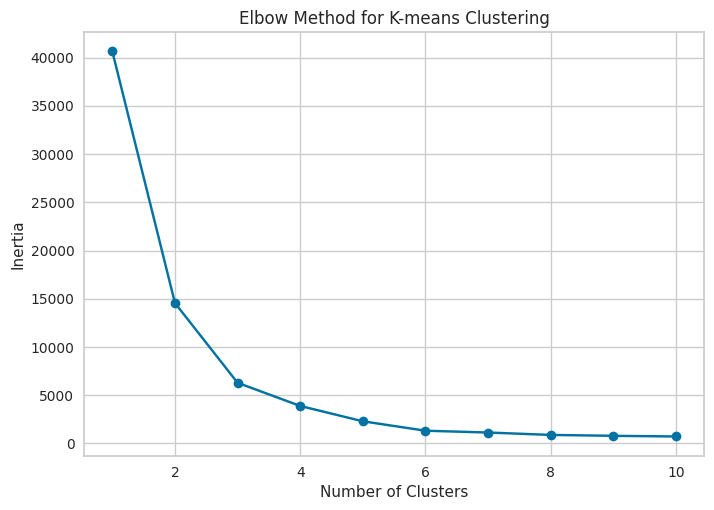

In [136]:
# 엘보우 메서드로 최적의 클러스터 개수 선정
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 'auto')
    kmeans.fit(data_clustering)
    inertias.append(kmeans.inertia_)

# 클러스터 개수에 따른 응집도 시각화
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-means Clustering')
plt.show()

#### K-means 클러스터링 진행

SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init='auto',
                                      random_state=1004))

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

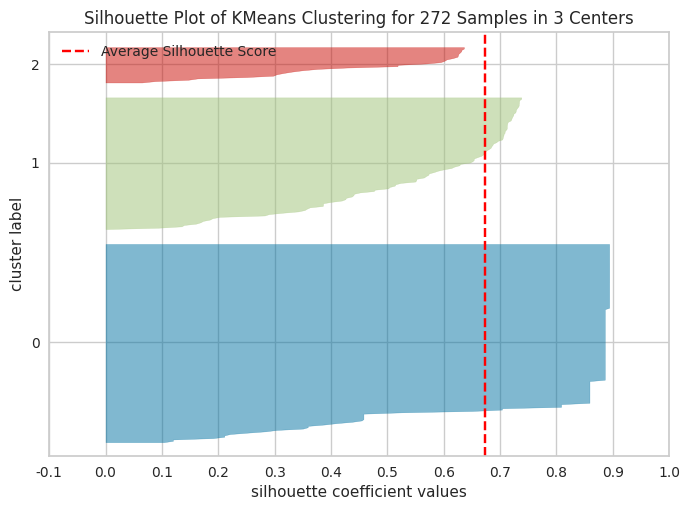

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 272 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [137]:
# 원본을 백업해두고 진행
cluster_data = data_clustering.copy()

# 클러스터링 객체 생성
kmeans = KMeans(n_clusters= 3, random_state= 1004, n_init = 'auto')

# print 함수 없이 출력하기 위한 설정
InteractiveShell.ast_node_interactivity = "all"

# 클러스터링 평가지표 시각화 visualizer 객체 생성
visualizer_n = SilhouetteVisualizer(kmeans, colors = "yellowbrick")

# 생성된 visualizer에 데이터 입력
visualizer_n.fit(cluster_data)

# 결과 출력
visualizer_n.show()

In [138]:
# 클러스터링 진행 
clusters = kmeans.fit(cluster_data)

# 백업을 위한 원본 데이터 복제
result_data = data_ori.copy()

# 분류된 클러스터 번호를 원본 데이터에 'cluster' feature로 삽입
result_data['cluster'] = clusters.labels_

# 결과 확인(5개 행)
result_data.head()

# 'Silhouette coefficient' 열 추가후 점수 확인
result_data.loc[:,'silhouette coefficient'] = visualizer_n.silhouette_samples_

# 최종 클러스터링 결과 확인
result_data.shape
result_data.head()

,행정동코드,자치구,행정동,장애인인구비율,급속충전소수,장애인콜택시도착건수,cluster
0,11110530,종로구,사직동,0.000681,3,14.25,1
1,11110540,종로구,삼청동,0.000281,0,0.00,0
2,11110550,종로구,부암동,0.000794,0,0.00,0
3,11110560,종로구,평창동,0.001253,0,9.00,1
4,11110570,종로구,무악동,0.000829,0,0.00,0


(272, 8)

,행정동코드,자치구,행정동,장애인인구비율,급속충전소수,장애인콜택시도착건수,cluster,silhouette coefficient
0,11110530,종로구,사직동,0.000681,3,14.25,1,0.683423
1,11110540,종로구,삼청동,0.000281,0,0.00,0,0.885810
2,11110550,종로구,부암동,0.000794,0,0.00,0,0.885821
3,11110560,종로구,평창동,0.001253,0,9.00,1,0.094778
4,11110570,종로구,무악동,0.000829,0,0.00,0,0.885821


In [139]:
# 전체 군집의 실루엣 계수 평균을 확인
print('전체 데이터의 실루엣 계수 평균')
result_data['silhouette coefficient'].mean()

# 평가지표인 실루엣 계수를 군집별로 확인
print('\n군집별 실루엣 계수 평균')
result_data.groupby('cluster')['silhouette coefficient'].mean().reset_index()

전체 데이터의 실루엣 계수 평균


0.6735270667423132


군집별 실루엣 계수 평균


,cluster,silhouette coefficient
0,0,0.792520
1,1,0.556363
2,2,0.450937


#### 클러스터링 최종 결과표를 통한 입지 후보 클러스터 선정

In [140]:
# 0번 클러스터의 10개 행 출력
cluster0 = result_data[result_data['cluster'] == 0]
cluster0.head(10)

,행정동코드,자치구,행정동,장애인인구비율,급속충전소수,장애인콜택시도착건수,cluster,silhouette coefficient
1,11110540,종로구,삼청동,0.000281,0,0.0,0,0.885810
2,11110550,종로구,부암동,0.000794,0,0.0,0,0.885821
4,11110570,종로구,무악동,0.000829,0,0.0,0,0.885821
5,11110580,종로구,교남동,0.000886,0,0.0,0,0.885822
6,11110670,종로구,창신1동,0.000674,0,0.0,0,0.885818
7,11110690,종로구,창신3동,0.000870,0,0.0,0,0.885822
9,11110650,종로구,혜화동,0.001473,0,6.0,0,0.457532
11,11140580,중구,장충동,0.000505,0,6.0,0,0.457530
12,11140680,중구,중림동,0.001345,1,0.0,0,0.893490
13,11140615,중구,신당동,0.001031,2,0.0,0,0.858562


In [141]:
# 1번 클러스터의 10개 행 출력
cluster1 = result_data[result_data['cluster'] == 1]
cluster1.head(10)

,행정동코드,자치구,행정동,장애인인구비율,급속충전소수,장애인콜택시도착건수,cluster,silhouette coefficient
0,11110530,종로구,사직동,0.000681,3,14.250000,1,0.683423
3,11110560,종로구,평창동,0.001253,0,9.000000,1,0.094778
8,11110515,종로구,청운효자동,0.001115,1,15.555556,1,0.723758
10,11140540,중구,회현동,0.000722,1,12.400000,1,0.582534
17,11170530,용산구,남영동,0.001325,2,10.857143,1,0.439795
23,11200540,성동구,마장동,0.002672,4,24.153846,1,0.289618
24,11200550,성동구,사근동,0.000906,0,16.000000,1,0.708126
26,11200650,성동구,성수1가1동,0.001480,3,15.250000,1,0.711844
32,11215870,광진구,구의3동,0.002021,0,19.000000,1,0.695937
34,11215830,광진구,자양2동,0.002391,0,16.000000,1,0.708126


In [142]:
# 2번 클러스터의 10개 행 출력
cluster2 = result_data[result_data['cluster'] == 2]
cluster2.head(10)

,행정동코드,자치구,행정동,장애인인구비율,급속충전소수,장애인콜택시도착건수,cluster,silhouette coefficient
31,11215860,광진구,구의2동,0.002680,3,36.230769,2,0.631462
45,11260680,중랑구,신내1동,0.005005,4,36.800000,2,0.630913
58,11305660,강북구,인수동,0.004517,4,33.545455,2,0.569059
71,11320522,도봉구,도봉2동,0.003769,6,32.833333,2,0.518413
76,11350611,노원구,하계1동,0.005089,4,67.333333,2,0.376442
80,11350630,노원구,상계1동,0.004877,4,28.266667,2,0.250320
86,11350695,노원구,상계6.7동,0.003223,6,71.666667,2,0.349643
87,11350625,노원구,중계2.3동,0.007901,6,29.266667,2,0.330709
92,11380560,은평구,구산동,0.005543,3,40.307692,2,0.625280
101,11380625,은평구,역촌동,0.005456,1,36.200000,2,0.616402


#### 최종 결과 시각화

In [143]:
# 최종 결과 데이터셋
result_data

,행정동코드,자치구,행정동,장애인인구비율,급속충전소수,장애인콜택시도착건수,cluster,silhouette coefficient
0,11110530,종로구,사직동,0.000681,3,14.250000,1,0.683423
1,11110540,종로구,삼청동,0.000281,0,0.000000,0,0.885810
2,11110550,종로구,부암동,0.000794,0,0.000000,0,0.885821
3,11110560,종로구,평창동,0.001253,0,9.000000,1,0.094778
4,11110570,종로구,무악동,0.000829,0,0.000000,0,0.885821
...,...,...,...,...,...,...,...,...
267,11740610,강동구,천호2동,0.004206,2,16.666667,1,0.737586
268,11740685,강동구,길동,0.005073,2,23.533333,1,0.385380
269,11740525,강동구,상일제1동,0.001689,1,36.909091,2,0.624304
270,11740526,강동구,상일제2동,0.002766,0,36.909091,2,0.605103


Text(0.5, 0, '장애인콜택시 도착 건수')

Text(0.5, 0.5, '장애인 인구 비율')

Text(0.5, 0, '전동휠체어 급속충전소 수')

Text(0.5, 0.92, '3D Plot of Clustering')

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

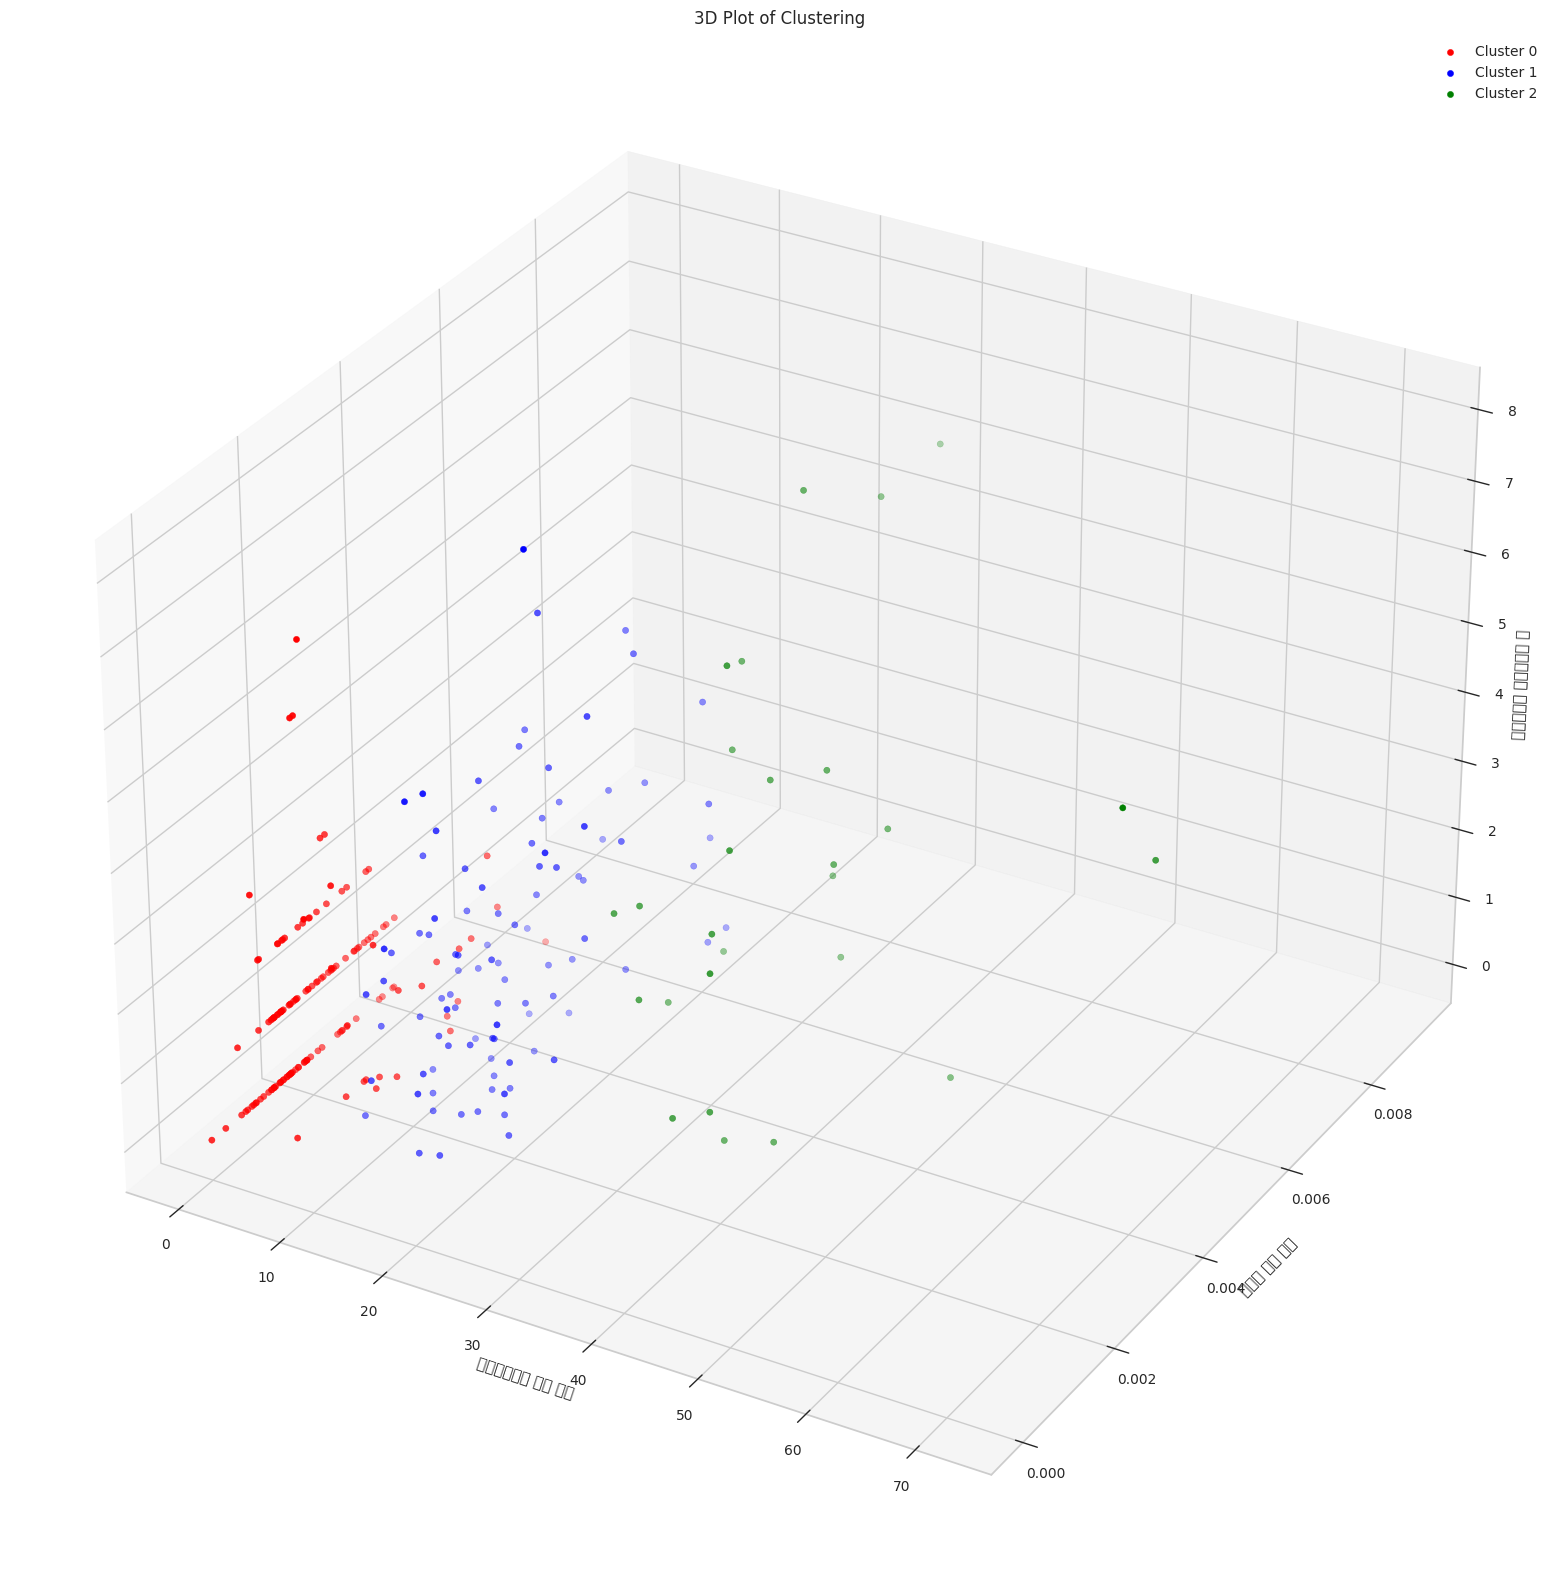

In [144]:
# 클러스터별 인덱스 추출
marker0 = result_data[result_data['cluster'] == 0].index
marker1 = result_data[result_data['cluster'] == 1].index
marker2 = result_data[result_data['cluster'] == 2].index

# 3D Plot 생성
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# 클러스터별 데이터 포인트를 색상별 표시
ax.scatter(result_data.loc[marker0, '장애인콜택시도착건수'], result_data.loc[marker0, '장애인인구비율'], result_data.loc[marker0, '급속충전소수'],
           c='red', label='Cluster 0')
ax.scatter(result_data.loc[marker1, '장애인콜택시도착건수'], result_data.loc[marker1, '장애인인구비율'], result_data.loc[marker1, '급속충전소수'],
           c='blue', label='Cluster 1')
ax.scatter(result_data.loc[marker2, '장애인콜택시도착건수'], result_data.loc[marker2, '장애인인구비율'], result_data.loc[marker2, '급속충전소수'],
           c='green', label='Cluster 2')

# 축 레이블 설정
ax.set_xlabel('장애인콜택시 도착 건수')
ax.set_ylabel('장애인 인구 비율')
ax.set_zlabel('전동휠체어 급속충전소 수')

# 그래프 제목 설정
ax.set_title('3D Plot of Clustering')

# 그래프 배경색 설정
ax.set_facecolor('white')

# 그래프 그리드 표시
ax.grid(True, linestyle='dotted', linewidth=0.5, alpha=0.7)

# 범례 표시
ax.legend()

# 시각화 결과
plt.show()

In [145]:
# result_data.to_csv('PCA데이터셋.csv', encoding = 'cp949', index = False)